<a href="https://colab.research.google.com/github/yasinsoylu1997/128_under/blob/main/ResNet50_models_128_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras


     |████████████████████████████████| 992 kB 4.9 MB/s 


In [3]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [4]:
X = []
y = []
image_size = 128
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:16<00:00, 82.78it/s] 


In [5]:
from imblearn.under_sampling import RandomUnderSampler 

reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomUnderSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
new_X = oversampled_X.reshape(-1,128,128,3)
oversampled_y

array(['COVID', 'COVID', 'COVID', ..., 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia'], dtype='<U15')

In [6]:
train_images, test_images,train_labels, test_labels = train_test_split(new_X , oversampled_y , test_size=0.25, random_state=42,shuffle=True)

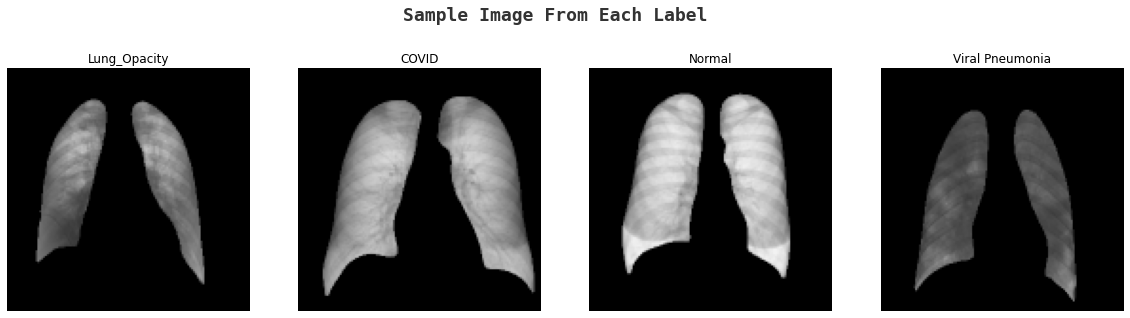

In [7]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y[j]==i:
            ax[k].imshow(X[j])
            ax[k].set_title(y[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

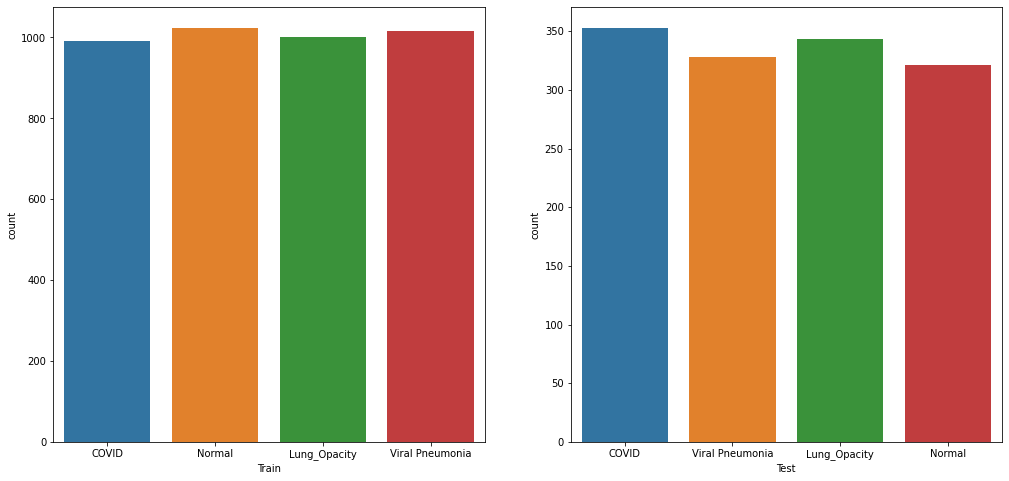

In [8]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [9]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [11]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [12]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [13]:
#Load model wothout classifier/fully connected layers
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in ResNet50_model.layers:
	layer.trainable = False
    
ResNet50_model.summary()  #Trainable parameters will be 0

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [14]:
#Now, let us use features from convolutional network for RF
feature_extractor=ResNet50_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_model= features #This is our X input for model

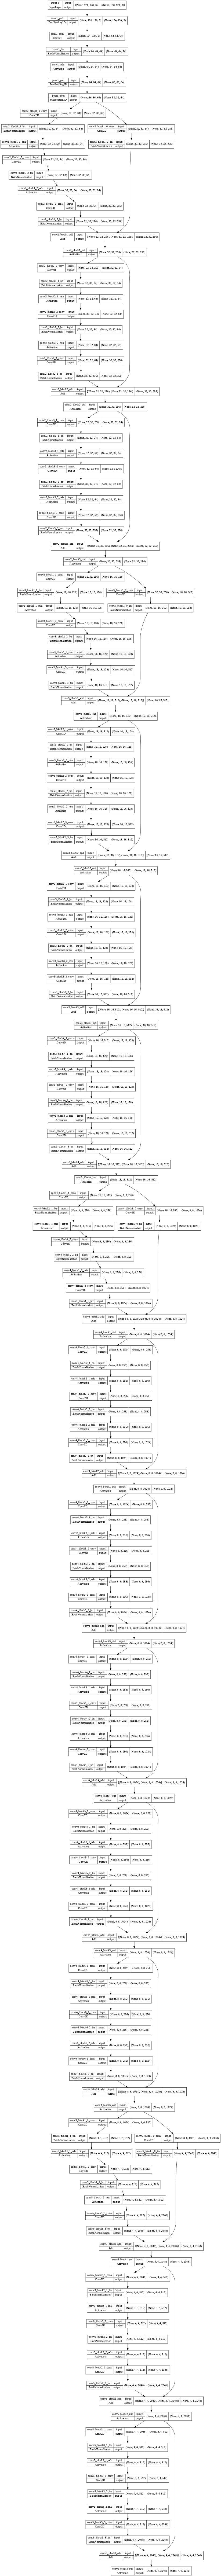

In [15]:
from keras.utils.vis_utils import plot_model

plot_model(ResNet50_model, to_file='model_plot_ResNet50_224.png', show_shapes=True, show_layer_names=True,dpi=50)

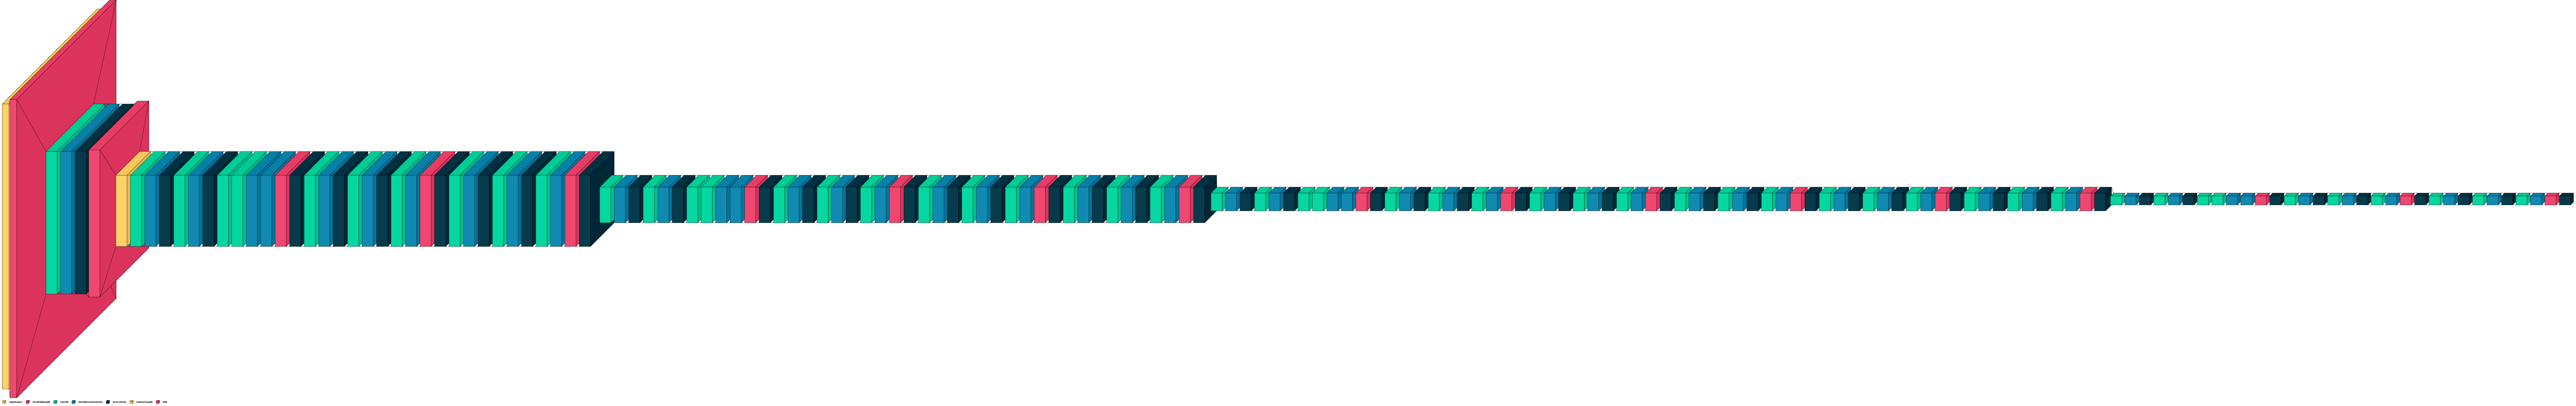

<Figure size 144x144 with 0 Axes>

In [16]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(ResNet50_model, legend=True,spacing=15,scale_xy = 10 , scale_z = 10, max_z = 50) 

In [17]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

# knn

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [19]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = knn_model.predict(X_test_features)

In [20]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.44312267657992566
MSE: 0.7063197026022305
RMSE: 0.8404282852226183
R2 Square 0.4400239460705042
Accuracy 0.6810408921933085
__________________________________


In [21]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, prediction) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.443123,0.70632,0.840428,0.440024,0.681041


In [22]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.56      0.64      0.60       353
           1       0.64      0.54      0.59       343
           2       0.63      0.66      0.65       321
           3       0.92      0.89      0.91       328

    accuracy                           0.68      1345
   macro avg       0.69      0.68      0.68      1345
weighted avg       0.69      0.68      0.68      1345



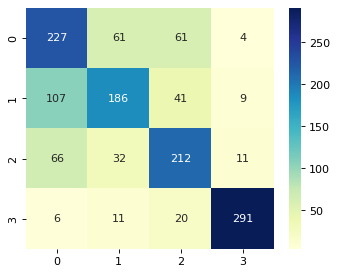

In [23]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [24]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [25]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = cart_model.predict(X_test_features)

In [26]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.6156133828996283
MSE: 1.0349442379182157
RMSE: 1.0173220915315935
R2 Square 0.17948771887383363
Accuracy 0.5724907063197026
__________________________________


In [27]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.443123,0.706320,0.840428,0.440024,0.681041
1,DecisionTreeClassifier,0.615613,1.034944,1.017322,0.179488,0.572491


In [28]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.45      0.43      0.44       353
           1       0.49      0.50      0.49       343
           2       0.53      0.55      0.54       321
           3       0.84      0.83      0.83       328

    accuracy                           0.57      1345
   macro avg       0.58      0.58      0.58      1345
weighted avg       0.57      0.57      0.57      1345



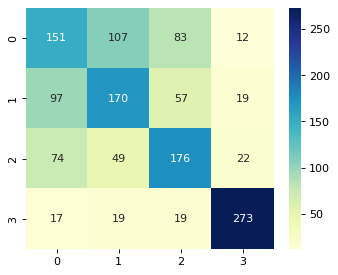

In [29]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [30]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [31]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = lr_model.predict(X_test_features)

In [32]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.4007434944237918
MSE: 0.6460966542750929
RMSE: 0.8038013773782009
R2 Square 0.48776927277396653
Accuracy 0.7152416356877324
__________________________________


In [33]:
results_df_2 = pd.DataFrame(data=[["LogisticRegression", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.443123,0.706320,0.840428,0.440024,0.681041
1,DecisionTreeClassifier,0.615613,1.034944,1.017322,0.179488,0.572491
2,LogisticRegression,0.400743,0.646097,0.803801,0.487769,0.715242


In [34]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.62      0.58      0.60       353
           1       0.69      0.67      0.68       343
           2       0.64      0.69      0.67       321
           3       0.91      0.92      0.92       328

    accuracy                           0.72      1345
   macro avg       0.72      0.72      0.72      1345
weighted avg       0.71      0.72      0.71      1345



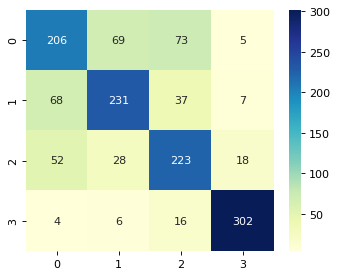

In [35]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [36]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [37]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = LGBM_model.predict(X_test_features)

In [38]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3546468401486989
MSE: 0.558364312267658
RMSE: 0.7472377883027986
R2 Square 0.557324193156788
Accuracy 0.7405204460966542
__________________________________


In [39]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.443123,0.706320,0.840428,0.440024,0.681041
1,DecisionTreeClassifier,0.615613,1.034944,1.017322,0.179488,0.572491
2,LogisticRegression,0.400743,0.646097,0.803801,0.487769,0.715242
3,LGBMClassifier,0.354647,0.558364,0.747238,0.557324,0.740520


In [40]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66       353
           1       0.69      0.67      0.68       343
           2       0.68      0.74      0.71       321
           3       0.93      0.91      0.92       328

    accuracy                           0.74      1345
   macro avg       0.74      0.74      0.74      1345
weighted avg       0.74      0.74      0.74      1345



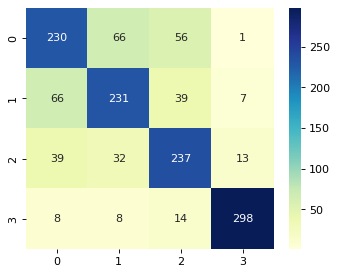

In [41]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [43]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = rf_model.predict(X_test_features)

In [44]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.37397769516728624
MSE: 0.5955390334572491
RMSE: 0.7717117554224823
R2 Square 0.527851769265762
Accuracy 0.7278810408921933
__________________________________


In [45]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.443123,0.706320,0.840428,0.440024,0.681041
1,DecisionTreeClassifier,0.615613,1.034944,1.017322,0.179488,0.572491
2,LogisticRegression,0.400743,0.646097,0.803801,0.487769,0.715242
3,LGBMClassifier,0.354647,0.558364,0.747238,0.557324,0.740520
4,RandomForestClassifier,0.373978,0.595539,0.771712,0.527852,0.727881


In [46]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.68      0.63      0.65       353
           1       0.66      0.68      0.67       343
           2       0.68      0.69      0.69       321
           3       0.89      0.92      0.91       328

    accuracy                           0.73      1345
   macro avg       0.73      0.73      0.73      1345
weighted avg       0.73      0.73      0.73      1345



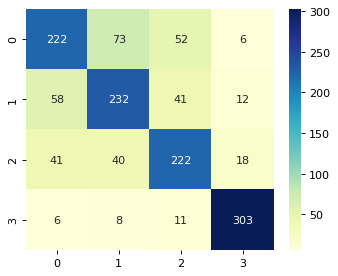

In [47]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [48]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [49]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GB_model.predict(X_test_features)

In [50]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.8
MSE: 1.2133828996282527
RMSE: 1.101536608392228
R2 Square 0.03802008419690839
Accuracy 0.3895910780669145
__________________________________


In [51]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.443123,0.706320,0.840428,0.440024,0.681041
1,DecisionTreeClassifier,0.615613,1.034944,1.017322,0.179488,0.572491
2,LogisticRegression,0.400743,0.646097,0.803801,0.487769,0.715242
3,LGBMClassifier,0.354647,0.558364,0.747238,0.557324,0.740520
4,RandomForestClassifier,0.373978,0.595539,0.771712,0.527852,0.727881
5,GaussianNB,0.800000,1.213383,1.101537,0.038020,0.389591


In [52]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.42      0.09      0.15       353
           1       0.32      0.89      0.47       343
           2       0.46      0.33      0.38       321
           3       0.80      0.26      0.39       328

    accuracy                           0.39      1345
   macro avg       0.50      0.39      0.35      1345
weighted avg       0.50      0.39      0.35      1345



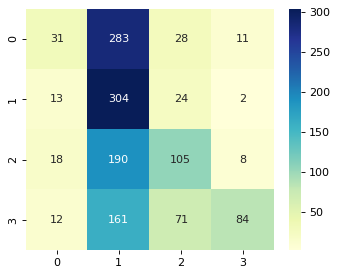

In [53]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [54]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [55]:
X_test_feature =ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = SGD_model.predict(X_test_features)

In [56]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.6237918215613383
MSE: 1.020817843866171
RMSE: 1.0103553057544514
R2 Square 0.19068723995242354
Accuracy 0.5732342007434944
__________________________________


In [57]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.443123,0.706320,0.840428,0.440024,0.681041
1,DecisionTreeClassifier,0.615613,1.034944,1.017322,0.179488,0.572491
2,LogisticRegression,0.400743,0.646097,0.803801,0.487769,0.715242
3,LGBMClassifier,0.354647,0.558364,0.747238,0.557324,0.740520
4,RandomForestClassifier,0.373978,0.595539,0.771712,0.527852,0.727881
5,GaussianNB,0.800000,1.213383,1.101537,0.038020,0.389591
6,SGDClassifier,0.623792,1.020818,1.010355,0.190687,0.573234


In [58]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.77      0.22      0.35       353
           1       0.80      0.30      0.44       343
           2       0.38      0.97      0.54       321
           3       0.96      0.85      0.90       328

    accuracy                           0.57      1345
   macro avg       0.73      0.59      0.56      1345
weighted avg       0.73      0.57      0.55      1345



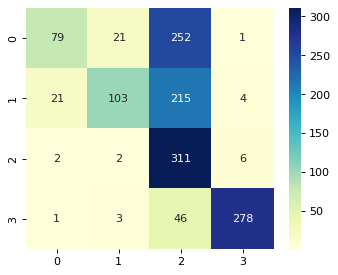

In [59]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SVC

In [60]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [61]:
X_test_feature = ResNet50_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svm_model.predict(X_test_features)

In [62]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.37174721189591076
MSE: 0.5888475836431227
RMSE: 0.7673640489644552
R2 Square 0.5331568055661466
Accuracy 0.7308550185873606
__________________________________


In [63]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_ResNet50' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.443123,0.706320,0.840428,0.440024,0.681041
1,DecisionTreeClassifier,0.615613,1.034944,1.017322,0.179488,0.572491
2,LogisticRegression,0.400743,0.646097,0.803801,0.487769,0.715242
3,LGBMClassifier,0.354647,0.558364,0.747238,0.557324,0.740520
4,RandomForestClassifier,0.373978,0.595539,0.771712,0.527852,0.727881
5,GaussianNB,0.800000,1.213383,1.101537,0.038020,0.389591
6,SGDClassifier,0.623792,1.020818,1.010355,0.190687,0.573234
7,SVC,0.371747,0.588848,0.767364,0.533157,0.730855


In [64]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.62      0.68      0.65       353
           1       0.68      0.64      0.66       343
           2       0.69      0.69      0.69       321
           3       0.95      0.92      0.94       328

    accuracy                           0.73      1345
   macro avg       0.74      0.73      0.73      1345
weighted avg       0.73      0.73      0.73      1345



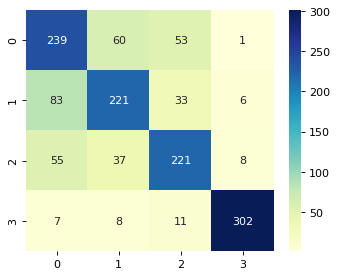

In [65]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [66]:
modeller = [rf_model,GB_model,LGBM_model,SGD_model,lr_model,cart_model,svm_model,knn_model]


In [67]:
sonuc = []
from sklearn.metrics import accuracy_score

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy_ResNet50"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_features)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy_ResNet50"])
    sonuclar = sonuclar.append(sonuc)
    

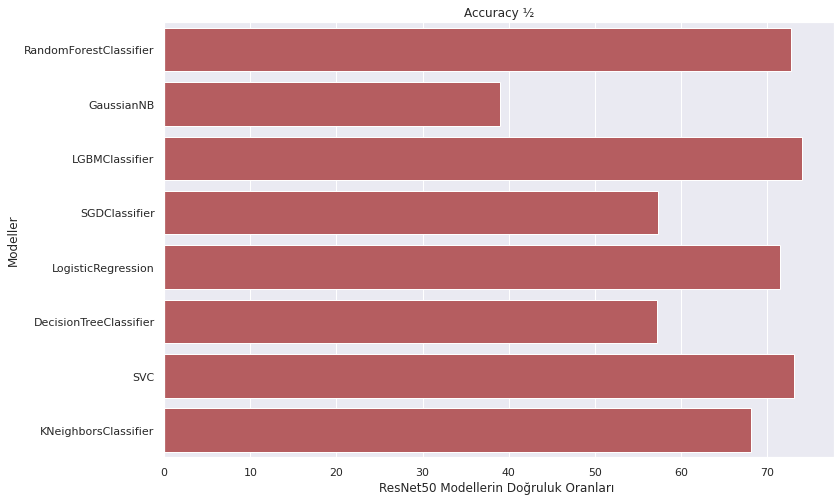

In [68]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x= 'Accuracy_ResNet50', y = 'Modeller', data=sonuclar, color="r")
plt.xlabel('ResNet50 Modellerin Doğruluk Oranları ')
plt.title('Accuracy ½'); 

In [69]:
best_acc=sonuclar.sort_values(by=['Accuracy_ResNet50'], ascending=False)
en_iyi_model_my_model=best_acc[:1]
en_iyi_model_my_model

,Modeller,Accuracy_ResNet50
0,LGBMClassifier,74.052045


In [70]:
results_df


,Model,MAE,MSE,RMSE,R2 Square,Accuracy_ResNet50
0,KNeighborsClassifier,0.443123,0.706320,0.840428,0.440024,0.681041
1,DecisionTreeClassifier,0.615613,1.034944,1.017322,0.179488,0.572491
2,LogisticRegression,0.400743,0.646097,0.803801,0.487769,0.715242
3,LGBMClassifier,0.354647,0.558364,0.747238,0.557324,0.740520
4,RandomForestClassifier,0.373978,0.595539,0.771712,0.527852,0.727881
5,GaussianNB,0.800000,1.213383,1.101537,0.038020,0.389591
6,SGDClassifier,0.623792,1.020818,1.010355,0.190687,0.573234
7,SVC,0.371747,0.588848,0.767364,0.533157,0.730855


In [71]:
from google.colab import files

results_df.to_csv('output_resnet50_224.csv', encoding = 'utf-8-sig') 
files.download('output_resnet50_224.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>